# TITLE: Signal Modulation and Detection in an AWGN Channel
Authors: ...
Last update: 6/12/2022

## Initialization

In [13]:
# Python packages
import os
import sys
import math
import numpy as np
from scipy.signal import welch
import matplotlib.pyplot as plt

current = os.getcwd()
parent = os.path.dirname(current)
sys.path.append(parent)
# Custom packages
from PyDSP_core.TX.Tx_generateBits import Tx_generateBits, nextpow2
from PyDSP_core.TX.setSignalParams import setSignalParams
from PyDSP_core.TX.pulseShaper import pulseShaper
from PyDSP_core.TX.QAM_config import QAM_config
from PyDSP_core.TX.Tx_QAM import Tx_QAM

from PyDSP_core.RX.setSNR import setSNR

from PyDSP_core.DSP.symDemapper import symDemapper
from PyDSP_core.DSP.rxDecision import BER_eval, EVM_eval
from PyDSP_core.DSP.LPF_apply import LPF_apply

## Input Parameters

In [14]:
SIG = {
    'M': 16,            #QAM constellation size
    'symRate': 60e9,    #total symbol-rate of the signal
    'modulation': 'QAM',#modulation type [QAM/PAM]
    'rollOff': 0.1,     #roll-off factor
    'nPol': 1,          #number of polarizations
    'nSyms': pow(2, 18) #total number of simulated symbols
}
nSpS =  2               #number of samples per symbol
SNR_dB = 15             #SNR in dB

## Set Transmitter Parameters

In [15]:
#Signal Parameters:
TX = {'SIG': setSignalParams('symRate', SIG['symRate'], 'M', SIG['M'], 'nPol', SIG['nPol'],
                             'nBpS', math.log2(SIG['M']), 'nSyms', SIG['nSyms'],
                             'roll-off', SIG['rollOff'], 'modulation', SIG['modulation'])
}
#Modulation Parameters:
TX['QAM'] = QAM_config(TX['SIG'])
#Bit Parameters:
TX['BIT'] = {'source': 'randi',
             'seed': 1
}
#Pulse Shaping Filter Parameters:
TX['PS'] = {'type': 'RC',
            'rollOff': TX['SIG']['rollOff'],
            'nTaps': 128
}
#DAC Parameters:
TX['DAC'] = {'RESAMP': {'sampRate':nSpS * TX['SIG']['symRate']}
}
#Matched-Filter Parameters:
MF= {
    'type': 'RC',
    'rollOff': TX['SIG']['rollOff']
}

## Generate Tx Bits

In [16]:
TX['BIT']['txBits'] = Tx_generateBits(SIG['nSyms'], TX['QAM']['M'], TX['QAM']['nPol'], TX['BIT'])

## Generate Transmitted Symbols

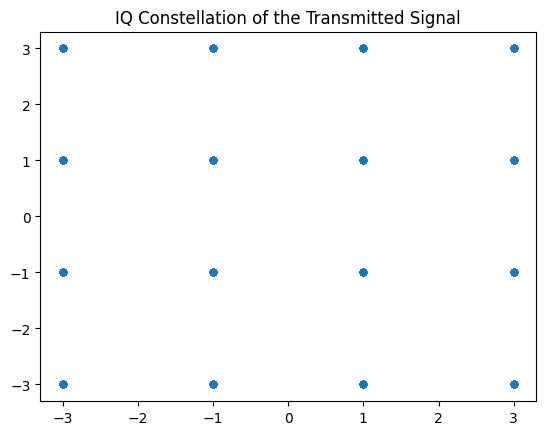

In [17]:
S = {}
S['tx'], TX['BIT']['txSyms'] = Tx_QAM(TX['QAM'], TX['BIT']['txBits'])

# Plot Transmitted Constellation Symbols:
plt.scatter(S['tx'].real, S['tx'].imag, s=20)
plt.title('IQ Constellation of the Transmitted Signal')
plt.show()

## Pulse Shaping

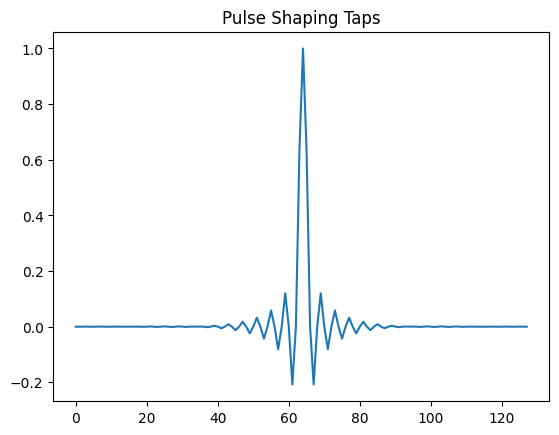

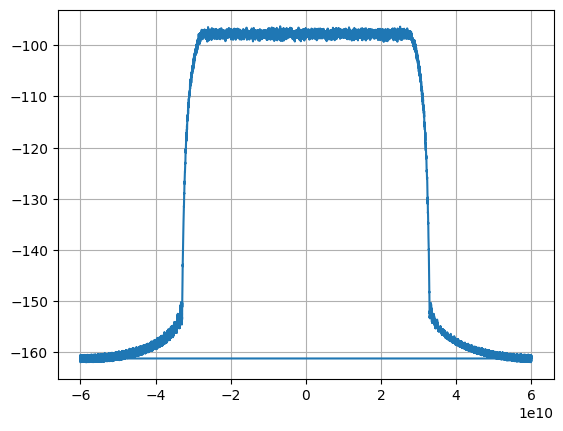

In [18]:
S['txSC'], TX['PS'] = pulseShaper(S['tx'], nSpS, TX['PS'])

#Plot Pulse Shaping Taps:
plt.plot(TX['PS']['W'])
plt.title('Pulse Shaping Taps')
plt.show()

# Plot Signal Spectrum:
# No matlab: pwelch(S.txSC(1,:),1e4,[],[],TX.DAC.RESAMP.sampRate,'centered')
#                  (x, window, noverlap, nfft, Fs, freqrange)
#
# window - If window is an integer, the signal is divided into segments of length window. The modified periodograms are computed using a Hamming window of length window.
# noverlap - If you do not specify noverlap, or specify noverlap as empty, the default number of overlapped samples is 50% of the window length.
# nfft - The default nfft is the greater of 256 or the next power of 2 greater than the length of the segments.

wind = np.hamming(pow(10,4))
nov = np.floor(pow(10,4)/2)
nff = max(256, pow(2,nextpow2(pow(10,4))))

f,Pxx = welch(S['txSC'][0],window = np.hamming(int(1e4)),noverlap=nov,nfft=nff,fs=TX['DAC']['RESAMP']['sampRate'],return_onesided=False ,detrend= False)
plt.plot(f,10*np.log10(Pxx))
plt.grid()
plt.show()

## Set SNR

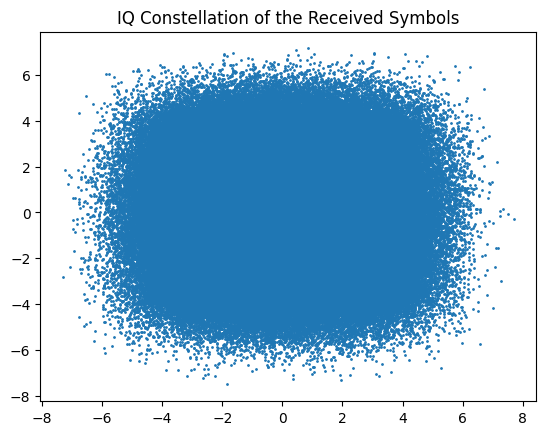

In [19]:
S['rx'] = setSNR(S['txSC'], SNR_dB, TX['DAC']['RESAMP']['sampRate'], SIG['symRate'])[0]

# Plot Received Constellation Symbols
plt.scatter(S['rx'].real, S['rx'].imag, s = 1)
plt.title('IQ Constellation of the Received Symbols')
plt.show()

## Apply Matched Filter

In [20]:
S['rx'] = LPF_apply(S['rx'],MF,TX['DAC']['RESAMP']['sampRate'],SIG['symRate'])[0]

## Downsample to 1 Sample/Symbol

In [21]:
S['rx_1sps'] = S['rx'][:,::nSpS]

## Apply Symbol Demapper

In [22]:
C = TX['QAM']['IQmap']
DEMAPPER,S['tx'] = symDemapper(S['rx_1sps'],S['tx'],C)

C:\Users\denys\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_optimize.py:772: ComplexWarning: Casting complex values to real discards the imaginary part
  fsim[k] = func(sim[k])
C:\Users\denys\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_optimize.py:838: ComplexWarning: Casting complex values to real discards the imaginary part
  fsim[-1] = fxcc
C:\Users\denys\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_optimize.py:811: ComplexWarning: Casting complex values to real discards the imaginary part
  fsim[-1] = fxr


Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 10
         Function evaluations: 20
Optimization terminated successfully.
         Current function value: 101695.012255
         Iterations: 11
         Function evaluations: 22


C:\Users\denys\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_optimize.py:826: ComplexWarning: Casting complex values to real discards the imaginary part
  fsim[-1] = fxc


Optimization terminated successfully.
         Current function value: 10273.737647
         Iterations: 17
         Function evaluations: 34


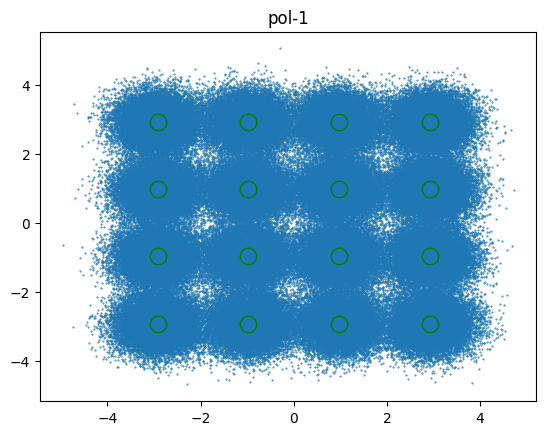

In [23]:
for n in range(0, SIG['nPol']):
    plt.scatter(S['rx_1sps'][n].real, S['rx_1sps'][n].imag, s=0.2)
    plt.scatter(DEMAPPER['C'][:,n].real, DEMAPPER['C'][:,n].imag,s=140, marker='o', edgecolor='g', facecolor=(0,1,0,0))
    plt.title('pol-'+str(n+1))
    plt.show()

In [24]:
BER = np.zeros(SIG['nPol'])
errPos = []
EVM = np.zeros(SIG['nPol'])
for n in range(0, SIG['nPol']):
    BER[n], errPos_aux = BER_eval(DEMAPPER['txBits'][n],DEMAPPER['rxBits'][n])
    errPos.append(errPos_aux)
    EVM[n] = EVM_eval(S['rx_1sps'][n],S['tx'][n])

for n in range(0, SIG['nPol']):
    print('BER'+str(n+1)+'= ',BER[n])
    print('EVM'+str(n+1)+'= ',EVM[n])

BER1=  0.010038375854492188
EVM1=  20.197495233493065
